# Project P3

`Auteur` : Romain Capocasale (INF2dlm-a)

`Date` : 01.10.2019

`Version de python` : 3.7.1

# Importation

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm
import spacy
import dill as pickle

# Chragement du jeu de données

In [2]:
dataset = pd.read_json('dataset/financialData.json')

# Analyse du jeu de données

In [3]:
dataset.head()

,sentiment,title
0,0.366,watching for bounce tomorrow
1,0.638,record number of passengers served in 2015
2,-0.494,out $NFLX -.35
3,0.460,Looking for a strong bounce Lunchtime rally co...
4,0.403,Very intrigued with the technology and growth ...


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2866 entries, 0 to 2865
Data columns (total 2 columns):
sentiment    2866 non-null float64
title        2866 non-null object
dtypes: float64(1), object(1)
memory usage: 44.9+ KB


In [5]:
dataset.describe()

,sentiment
count,2866.000000
mean,0.079841
std,0.391033
min,-1.000000
25%,-0.285000
50%,0.206000
75%,0.387000
max,1.000000


Le jeu de données contient 2 colonnes :
    - sentiment : le sentiment de la pharse, -1 pour positif et 1 pour positif
    - title : la phrase en question

# Répartition des classes

In [6]:
nb_pos, nb_neg, nb_ntr = len([sent for sent in dataset.sentiment if sent > 0]), len([sent for sent in dataset.sentiment if sent < 0]), len([sent for sent in dataset.sentiment if sent == 0])
tot = len(dataset)
print("Number of data : {}".format(tot))
print("Number of positive data : {} ({}%)".format(nb_pos, round( nb_pos/tot*100, 3)))
print("Number of negative data : {} ({}%)".format(nb_neg, round( nb_neg/tot*100, 3)))
print("Number of neutral data : {} ({}%)".format(nb_ntr, round( nb_ntr/tot*100, 3)))
print("Ratio positive/negative : {}".format(round(nb_pos/nb_neg, 3)))

Number of data : 2866
Number of positive data : 1756 (61.27%)
Number of negative data : 1045 (36.462%)
Number of neutral data : 65 (2.268%)
Ratio positive/negative : 1.68


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001612B38C748>]],
      dtype=object)

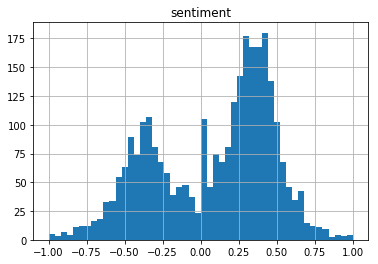

In [7]:
dataset.hist(bins=50)

On remarque qu'il y a beaucoup plus de phrase avec un sentiment positif que négatif. On remarque égalemne sur le graphe 2 pics, un pour les sentiments négatifs aux alentours de -0.40 et un pour les sentiment négatifs

# Nombre de mot moyen par phrase

In [8]:
def average_word_by_sentence(sentences):
    nb_total_word = 0
    for row in sentences:
        nb_total_word += len(row.split())
    return round(nb_total_word / len(sentences), 3)

In [9]:
print("Average of word by sentence : {}".format(average_word_by_sentence(dataset['title'])) )

Average of word by sentence : 7.515


Text(0, 0.5, 'Number of sentence')

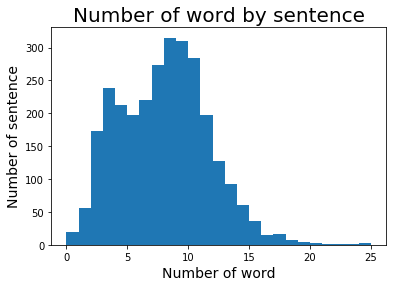

In [10]:
num_word_by_sentence = [len(x.split()) for x in dataset['title']]#count the number of word for each sentences

plt.hist(num_word_by_sentence, bins=25)
plt.title('Number of word by sentence', fontsize=20)
plt.xlabel('Number of word', fontsize=14)
plt.ylabel('Number of sentence', fontsize=14)

On remarque que la moyenne de nombre de mot par phrase est de **7.515** et on peut voir sur le graphe la répartirion du nombre de mot par phrase.

# Récupération des valeurs x et y

In [3]:
X = dataset['title']
y = dataset['sentiment']

# Séparation du jeu d'entrainement et jeu de test 
Je n'utilise pas la classe StratifiedShuffleSplit qui assure une répartition équitable entre le nombre de phrase positive et négative dans le jeu de test et le jeu d'entrainement car étant donné qu'il y a beaucoup plus de phrase positive que négative on perderait une grande partie du jeu de donnée.
Le jeu d'entrainement est séparé en 2 parties, La première partie est le jeu d'entrainement qui sera utilisé pour la création du modèle d'analyse de sentiment. Le jeu de test sera lui utilisé pour tester la qualité des modèles évalués.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Definition des méthode de calcul de score
La méthode print_scores() permet de calculer la RMSE, la MAE et la précision à partir des vrai étiquettes et des étiquettes prédites. Il est également possible d'indiquer le seuil désiré, le seuil permet de definir pour une prédiction si elle doit considéré come positive ou négative. La méthode regression_score_to_classification() permet de transformer les étiquettes du format régression au format classification. Les étiquettes de -1 à seuil sont mise à 0 et celles de seuil à 1 sont mise à 1.

In [5]:
def regression_score_to_classification(labels, threshold):
    '''Set to 0 regression prediction between -1 and thresold, set to 1 regression preiction between thresold and 1
    Allow to pass from regression prediction to classification prediction
    
    labels -- list of regression score
    thresold -- thresold
    
    return -- list of labels either 0 or 1
    '''
    y_clf = []
    for y in labels:
        if y <= threshold:
            y_clf.append(0)
        elif y > threshold:
            y_clf.append(1)
    return np.array(y_clf)
        

def print_scores(name, y_test, y_pred, threshold=0, show_classification_report=False):
    '''Display the RMSE, MAE and accuracy for a model
    
    name -- name of the model
    y_test -- true data
    y_pred -- predicted data 
    threshold=0 -- threshold
    show_classification_report=False -- display the score with sklearn.metrics.classification_report function
    
    '''
    print("RMSE for {} : {}".format(name, np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    print("MAE for {} : {}".format(name, metrics.mean_absolute_error(y_test, y_pred)))
    
    y_test_clf = regression_score_to_classification(y_test, threshold)
    y_pred_clf = regression_score_to_classification(y_pred, threshold)
    print("Accuracy for {} : {}".format(name, metrics.accuracy_score(y_test_clf, y_pred_clf)))
    if show_classification_report:
        print(metrics.classification_report(y_test_clf, y_pred_clf))

# Score de textblob et VADER
Nous allons comparé le score de l'analyseur de sentiment de VADER(nltk) et textblob sur le jeu d'entrainement. Il est à noté que les phrases ne sont pas prétraité avant d'être envoyé aux analyseur de sentiment. En effet, ces 2 analyseur posséde leur propre méthode de prétraitement de texte. Les scores obtenus ici seront utilisé comme score de référence pour l'évaluation des futures modèles. Le but des futures modèles est de battre ces scores.

In [57]:
y_pred_textblob = []

for x in X_test:
    blob_analyser = TextBlob(x)
    y_pred_textblob.append(blob_analyser.polarity)
    
y_pred_textblob = np.array(y_pred_textblob)
print_scores('textblob', y_test, y_pred_textblob)

RMSE for textblob : 0.3946489568269569
MAE for textblob : 0.3349477944641503
Accuracy for textblob : 0.5243128964059197


In [59]:
vader_analyser = SentimentIntensityAnalyzer()

y_pred_vader = []
for x in X_test:
    y_pred_vader.append(vader_analyser.polarity_scores(x)['compound'])

y_pred_vader = np.array(y_pred_vader)
print_scores('VADER', y_test, y_pred_vader)

RMSE for VADER : 0.410972061994435
MAE for VADER : 0.33345084566596195
Accuracy for VADER : 0.5412262156448203


On constate que les résultats obtenus sont plutot muavais. I est alors intéressant de créer un modèle dans le but d'obtenir de meilleurs résultats.

# Traitement du texte
Le traitement du texte est effectué avec la librairie spacy. Dans un premier temps, on créé une classe héritant de BaseEstimator et de TransformerMixin. Le fait d'heriter de ces 2 classes permettera d'inclure cette classe dans le pipeline sklearn. Différent paramétres pour le prétraitement du texte sont défini dans le constructeur. Le principale avantage de cette méthode est qu'elle se combine avec l'utilisation de la classe GridSearchCV() qui permet de chercher les meilleurs hyper-parametrès pour un modèle. La classe doit implémenter la méthode fit() qui permet d'effectuer une estimation dans notre cas elle retournera self comme la classe n'effectue aucune estimation. La seconde méthode est transform() qui permet de transformer le texte, donc dans notre cas de prétaiter le texte. Le pipeline s'occupe d'appeler automatiquement les bonnes méthodes.

Pour le prétraitement, différentes processus sont effectués sur la phrase:
 * **Tokenisation** : consiste à découper la phrase en mot.
 * **Suppression des ``stop word``** : suppresion des mots comme ``the``, ``are``, etc. Ce paramétre est configurable via le constructeur
 * **Tagging et suppression de certains mots tagués** : le tagging consiste à detecter le type du mot comme par exemple ``nom``, ``adjectif``, ``verbe``, etc. Par la suite, il faut supprimer le type de mot que l'on ne veut pas garder dans la phrase. Actuellement, les verbes, adverbes, nom et adjectifs sont conservés. Ce paramétre est configurable via le constructeur.
 * **Taille du mot** : consiste à garder que les mots d'une certaines taille. Ce paramétre est configurable via le constructeur.
 * **Suppresion de la ponctuation** : suppresion des caractère comme ``!``, ``?``, etc.
 * **Lemmatisation** : consiste à ne garder que la racine des mots dans le but de réduire la taille du dictionnaire. Par exemple, les mots comme ``runs``, ``running`` seront transformer en ``run``.

In [6]:
nlp = spacy.load('en')
class TextProcessor(BaseEstimator, TransformerMixin):
    '''Class use in pipeline to processing the text'''
    def __init__(self, remove_stop_word=False, keep_only_good_word=True, min_word_size=2):
        '''Constructor of TextProcessor
        
        remove_stop_word=False -- remove stop word in the sentence
        keep_only_good_word=True -- keep only the verb, adverb, noun and adjectiv otherwise keep all the word type
        min_word_size=2 -- remove all the word smaller that min_word_size, -1 to ignore this param
        '''
        self.remove_stop_word = remove_stop_word
        self.keep_only_good_word = keep_only_good_word
        self.min_word_size = min_word_size
        self.good_words = ['VERB', 'ADV', 'NOUN', 'ADJ']
        
        self.punctuations = string.punctuation
        
    def spacy_text_processing(self, sentence):
        '''Process the sentence, Cut the sentence in word, according to the parameters : deletes the stop word, 
        keeps only or not the verbs, adjectives, noun and adverb, deletes the words below a certain size, 
        removes the punctuation, and keeps only the roots of the word.
        
        sentence -- sentence to transform
        '''
        final_sentence = []
        for word in nlp(sentence):
            if self.remove_stop_word:
                if word.is_stop:
                    continue
            
            if self.keep_only_good_word:
                if word.pos_ not in self.good_words:
                    continue
                    
            if self.min_word_size!=-1:
                if len(word.text) < self.min_word_size:
                    continue
                    
            if word.text not in self.punctuations:
                final_sentence.append(word.lemma_)
        return final_sentence
        
    def transform(self, X, y=None):
        '''Transform the text, call by the pipeline
        
        X -- data
        y=None -- labels of the data
        '''
        X_transformed = []
        for sentence in X:
            X_transformed.append(' '.join(self.spacy_text_processing(sentence)))
        return X_transformed
    
    def fit(self, X, y=None):
        '''Use for estimation
        
        X -- data
        y=None -- labels of the data
        '''
        return self

# Création des pipelines et entrainement des modeles
Un pipeline est créé pour chaque type de modèle. Trois types de modèles ont été selectionné : 
 * la régression linéaire
 * la machine à vecteur de support 
 * la Foret aléatoire
 
Le pipeline commence par prétraité le texte avec la classe TextProcessor() créé précedemment, puis transformer la phrase en vecteur, effectuer la transformation Tfidf et pour finir l'ajout du modèle en question.
 
Pour finir les différents pipelines sont entrainés avec les données d'entrainements.

In [8]:
lr_model = Pipeline([('text_processing', TextProcessor()),
                    ('vectorizer', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('lr', LinearRegression())])

svr_model = Pipeline([('text_processing', TextProcessor()),
                    ('vectorizer', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('svr', SVR(kernel='poly'))])

rfr_model = Pipeline([('text_processing', TextProcessor()),
                    ('vectorizer', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('rfr', RandomForestRegressor())])

lr_model.fit(X_train, y_train)
svr_model.fit(X_train, y_train)
rfr_model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('text_processing',
                 TextProcessor(keep_only_good_word=True, min_word_size=2,
                               remove_stop_word=False)),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocesso...
                                  sublinear_tf=False, use_idf=True)),
                ('rfr',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
    

# Evaluation des modèles
Le score des modèles est calculé avec le jeu de test. On remarque que pour la MAE et la RMSE seul le modèle Random Forest Regressor obtient de meilleurs résultats que les analyseurs preccedents. On peut également constaté qu'au niveau de la précision (Accuracy en anglais) tous les modèles ont un meilleur score que les analyseurs préceddent et que la Random Forest Regressor obtient presque une précision de 80%.
Il faudrait maintenant entrainé ces modèles avec une techinque comme la GridSearchCV() afin d'optimiser les hyper-parametres et d'obtenir encore de meilleurs résultats.

In [16]:
y_pred_lr = lr_model.predict(X_test)
print_scores('Linear regression', y_test, y_pred_lr)
print("\n")
y_pred_svr = svr_model.predict(X_test)
print_scores('Support Vector Regression', y_test, y_pred_svr)
print("\n")
y_pred_rfr = rfr_model.predict(X_test)
print_scores('Random forest regressor', y_test, y_pred_rfr)

RMSE for Linear regression : 0.507525533756625
MAE for Linear regression : 0.34263749604820276
Accuracy for Linear regression : 0.7124735729386892


RMSE for Support Vector Regression : 0.4026153740288686
MAE for Support Vector Regression : 0.32564693434181574
Accuracy for Support Vector Regression : 0.6173361522198731


RMSE for Random forest regressor : 0.3051924807251932
MAE for Random forest regressor : 0.22171353937922397
Accuracy for Random forest regressor : 0.7843551797040169


# Recherche par quadriallage
Dans le but d'améliorer encore la performance des modèles, il est possible d'effectuer une recherche par quadriallage  pour trouver les meilleures hyperparamètres. Les parametrès à tester se trouve dans le dictionnaire. La clé corresponds au nom du paramètre à tester et la valeur correponds au différentes valeurs que peuvnent prendre les hyperparamètres. 

In [10]:
param_grid_rfr = {
    'text_processing__keep_only_good_word':(True, False), 
    'text_processing__remove_stop_word': (True, False),
    'text_processing__min_word_size' : [-1, 2,3,4,5],
    'tfidf__use_idf' : (True, False),
    'rfr__n_estimators' : [3,10,30],
    'rfr__max_features' : [2,4,6,8],
    'rfr__bootstrap' : (True, False)
}

rfr_grid_model = Pipeline([('text_processing', TextProcessor()),
                    ('vectorizer', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('rfr', RandomForestRegressor())])

random_search_rfr = RandomizedSearchCV(rfr_grid_model, param_grid_rfr,scoring='neg_mean_absolute_error',  n_iter=30, verbose=3, n_jobs=-1)
random_search_rfr.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


PicklingError: Could not pickle the task to send it to the workers.

In [24]:
random_search_rfr.best_params_

{'tfidf__use_idf': False,
 'text_processing__remove_stop_word': False,
 'text_processing__min_word_size': 4,
 'text_processing__keep_only_good_word': False,
 'rfr__n_estimators': 10,
 'rfr__max_features': 8,
 'rfr__bootstrap': False}

On peut voir ci dessus les meilleurs paramètres à utiliser pour maximiser les performances de notre modèle. Ci-dessous on peut voir chaque combinaison de valeurs testé avec le score obtenu.

In [25]:
cvres = random_search_rfr.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
    print(-mean_score, params)

0.2590588727618 {'tfidf__use_idf': False, 'text_processing__remove_stop_word': True, 'text_processing__min_word_size': -1, 'text_processing__keep_only_good_word': True, 'rfr__n_estimators': 10, 'rfr__max_features': 4, 'rfr__bootstrap': True}
0.2497169053269151 {'tfidf__use_idf': False, 'text_processing__remove_stop_word': True, 'text_processing__min_word_size': 4, 'text_processing__keep_only_good_word': True, 'rfr__n_estimators': 30, 'rfr__max_features': 6, 'rfr__bootstrap': False}
0.2536001050468287 {'tfidf__use_idf': False, 'text_processing__remove_stop_word': False, 'text_processing__min_word_size': 4, 'text_processing__keep_only_good_word': False, 'rfr__n_estimators': 10, 'rfr__max_features': 8, 'rfr__bootstrap': True}
0.2781702663581134 {'tfidf__use_idf': False, 'text_processing__remove_stop_word': False, 'text_processing__min_word_size': -1, 'text_processing__keep_only_good_word': True, 'rfr__n_estimators': 3, 'rfr__max_features': 2, 'rfr__bootstrap': True}
0.24680139165988285 {'

## Calcul des scores pour la recherche par quadrillage
Même si le score ``MAE`` à déja été lors de la recherche par quadrillage, il est intéressant de calculer les autres scores. On peut voir que les résultats s'améliorent à peine plus qu'a l'étape d'avant.

In [26]:
y_pred_rfr_grid = random_search_rfr.predict(X_test)
print_scores('Random forest regressor', y_test, y_pred_rfr_grid)

RMSE for Random forest regressor : 0.2924582119510245
MAE for Random forest regressor : 0.2029450322807975
Accuracy for Random forest regressor : 0.7970401691331924


In [ ]:
param_grid_svr = {
        'tfidf__use_idf' : (True, False),
        'svr__kernel': ('linear', 'rbf', 'poly', 'sigmoid'),
        'svr__gamma': np.logspace(-9, 3, 13),
        'svr__C': np.logspace(-2, 10, 13),
} 
tp = TextProcessor(remove_stop_word=False, keep_only_good_word=False, min_word_size=4)
X_train_processed = tp.fit_transform(X_train)

svr_grid_model = Pipeline([
                           ('vectorizer', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('svr', SVR())])

grid_search_svr = GridSearchCV(svr_grid_model, param_grid_svr,scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_search_svr.fit(X_train_processed, y_train)


In [ ]:
import sklearn.externals.joblib.externals.loky.backend.